In [1]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


Text(0.5, 1.0, 'White wine quality classes')

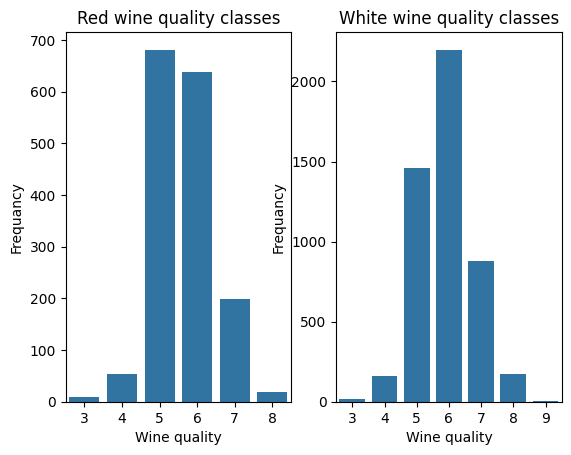

In [1]:
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, f1_score
from sklearn import svm, neural_network, linear_model
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
# divide into red/white dataset
red_x = X.iloc[:1598].values
white_x = X.iloc[1599:].values
red_y = np.ravel(y.iloc[:1598].values)
white_y = np.ravel(y.iloc[1599:].values)

# classes distribution
plt.subplot(1,2,1)
sns.countplot(x= red_y)
plt.xlabel('Wine quality')
plt.ylabel('Frequancy')
plt.title('Red wine quality classes')
plt.subplot(1,2,2)
sns.countplot(x= white_y)
plt.xlabel('Wine quality')
plt.ylabel('Frequancy')
plt.title('White wine quality classes')

In [2]:
class model_selection():
    def __init__(self, MR=False, nn=False, SVM=False, randomforest=False, ada=False, gra=False):
        self.MR = MR
        self.nn = nn
        self.SVM = SVM
        self.forest = randomforest
        self.ada = ada
        self.gra = gra
    def build_model(self):
        if self.MR == True:
            md = linear_model.Lasso()
            return md
        elif self.nn == True:
            return neural_network.MLPRegressor(alpha=1e-3,
                        hidden_layer_sizes=(16, 128), random_state=42)
        elif self.SVM == True:
            md = svm.SVR(kernel='rbf', tol=0.25)
            return md
        elif self.forest == True:
            return RandomForestRegressor(random_state=42, n_estimators=100)
        elif self.ada == True:
            return AdaBoostRegressor(random_state=42)

        



Kappa: 0.9454055604708628
Mean absolute deviation: 0.06075373619233268
F1 score: 0.9533004667544397
Kappa: 0.9491790550921584
Mean absolute deviation: 0.056548586285342865
F1 score: 0.9567482684952487
Kappa: 0.9510671202454207
Mean absolute deviation: 0.055573610659733506
F1 score: 0.9582217600059453
Kappa: 0.9548721107591224
Mean absolute deviation: 0.04777380565485863
F1 score: 0.9614183673653569
Kappa: 0.9522107911100943
Mean absolute deviation: 0.05394865128371791
F1 score: 0.959197281635287


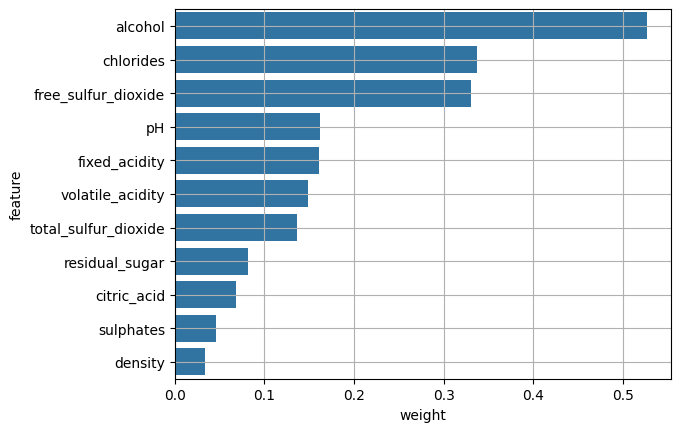

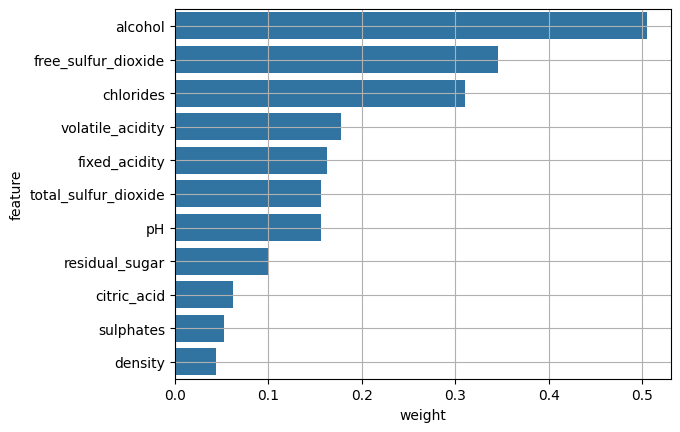

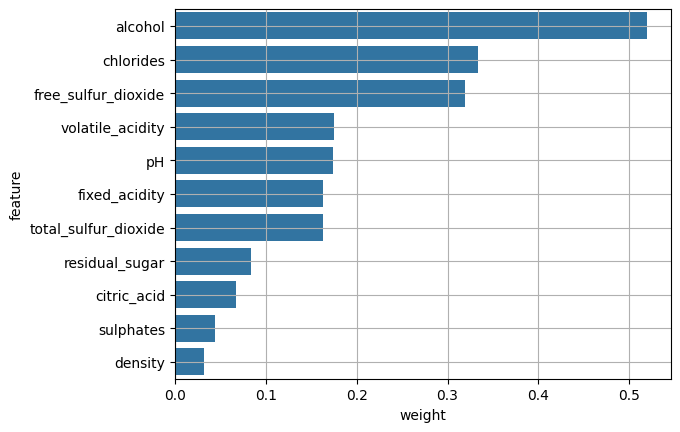

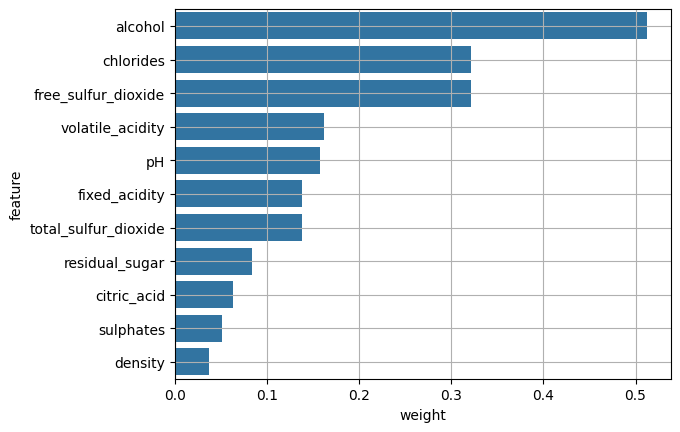

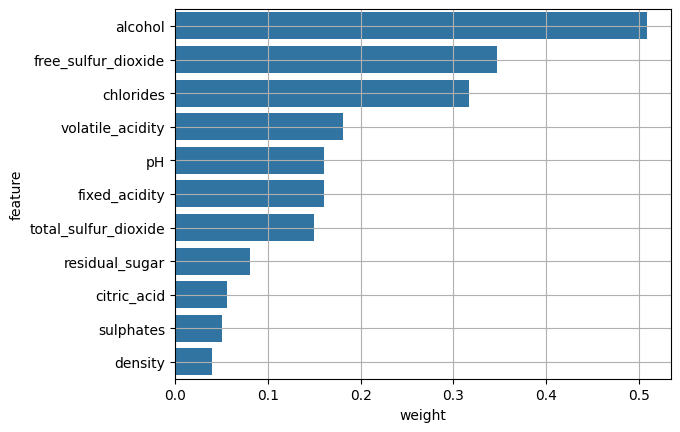

<Figure size 640x480 with 0 Axes>

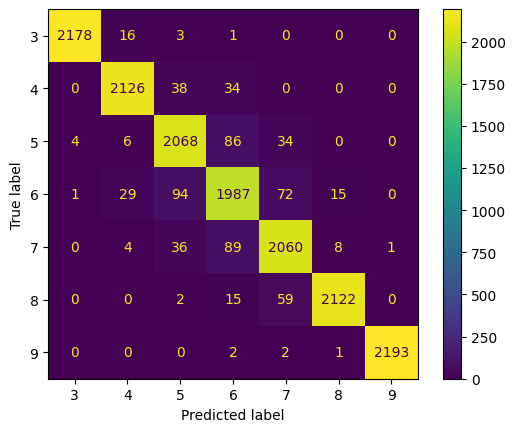

In [28]:
# white wine
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler
scaler = StandardScaler()
white_x = scaler.fit_transform(white_x)
# PCA
# white_x = PCA(n_components=2).fit_transform(white_x)

# SMOTE+tomeklinks
smote = SMOTE(random_state=42, k_neighbors=4)
white_x, white_y = smote.fit_resample(white_x, white_y)
tomek_links = TomekLinks()
white_x, white_y = tomek_links.fit_resample(white_x, white_y)

# cross-validation K=5
cf_matrix = []
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)  

# train the model
obj = model_selection(randomforest=True)  # choose the algorithm
md = obj.build_model()
T = 1
cf_matrix = np.zeros([5,7,7])
inx = 0
for train_id, test_id in k_fold.split(white_x):
    X_train, X_test = white_x[train_id], white_x[test_id]
    y_train, y_test = white_y[train_id], white_y[test_id]
    md.fit(X=X_train, y=y_train)
    pred_label = md.predict(X_test)
    for i in range(pred_label.shape[0]):
        if abs(pred_label[i]-y_test[i])<=T:
            pred_label[i] = y_test[i]
        else:
            pred_label[i] = round(pred_label[i])
    kappa = cohen_kappa_score(y_test, pred_label)
    mae = mean_absolute_error(y_test, pred_label)
    f = f1_score(y_test, pred_label, average='weighted')
    cf_matrix[inx] = confusion_matrix(y_test, pred_label, labels=[3, 4, 5, 6, 7, 8, 9])
    print("Kappa: {}".format(kappa))
    print("Mean absolute deviation: {}".format(mae))  # MAD
    print("F1 score: {}".format(f))  # F1 score: （precision, recall）
    plt.figure()
    result = permutation_importance(md, X_test, y_test, n_repeats=5, random_state=42)
    importance = result.importances_mean
    importance = pd.DataFrame({
    'feature' : X.columns,
    'weight' : importance
    }).sort_values(by='weight', ascending=False).reset_index(drop=True)
    sns.barplot(x=importance.weight, y=importance.feature).grid('both')   # randomforest feature importances
    inx+=1

plt.figure()
out = ConfusionMatrixDisplay(np.sum(cf_matrix, axis=0).astype(int), display_labels=[3, 4, 5, 6, 7, 8, 9])   # Confusion matrix 
out.plot()
plt.show()
